In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from load_data_every20 import load_images, CustomTensorDataset
from load_data_simulated import load_synth_images
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms       
#init_transforms = transforms.Compose([transforms.CenterCrop(128)])
init_transforms = transforms.Compose([transforms.Resize((128,128))])#,transforms.Normalize([0.5],[0.5])])
init_transforms_target = transforms.Resize((128,128))

#tensor_x, tensor_y, tensor_x_test, tensor_y_test = load_images()
tensor_x, tensor_y = load_images()
#tensor_x_sim, tensor_y_sim = load_synth_images()
tensor_x, tensor_x_val, tensor_y, tensor_y_val = train_test_split(tensor_x, tensor_y, test_size=0.2, random_state=1)

tensor_x_val =   tensor_x_val/255
tensor_y_val =   tensor_y_val/255
tensor_x =       tensor_x/255
tensor_y =       tensor_y/255
#tensor_x_sim = init_transforms(tensor_x_sim/255)
#tensor_y_sim = init_transforms(tensor_y_sim/255)
#print(tensor_x_sim.shape)

print(tensor_x.shape)
print(tensor_y.shape)
tensor_x = init_transforms(tensor_x) #/255
tensor_y = init_transforms_target(tensor_y) #/255
print(tensor_x.shape)
print(tensor_y.shape)
#tensor_x = torch.cat((tensor_x,tensor_x_sim))
#tensor_y = torch.cat((tensor_y,tensor_y_sim))
#tensor_x = tensor_x[:32]
#tensor_y = tensor_y[:32]
tensor_x_val = init_transforms(tensor_x_val) #/255
tensor_y_val = init_transforms_target(tensor_y_val) #/255
#tensor_x_test = init_transforms(tensor_x_test) /255
#tensor_y_test = init_transforms(tensor_y_test) /255
print(tensor_x.shape)
print(tensor_y.shape)


#my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset

my_dataset = CustomTensorDataset(tensors=(tensor_x,tensor_y),transform=True,hflip_p=0.5,vflip_p=0.5)
#my_dataset_test = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
my_dataset_val = TensorDataset(tensor_x_val,tensor_y_val)

my_dataloader = DataLoader(my_dataset,shuffle=True,batch_size=2)#, batch_size=1) # create your dataloader
#my_dataloader_test = DataLoader(my_dataset_test)
my_dataloader_val = DataLoader(my_dataset_val)
print(len(my_dataloader.dataset))


torch.Size([802, 210, 381])
torch.Size([802, 210, 381])
torch.Size([802, 128, 128])
torch.Size([802, 128, 128])
torch.Size([802, 128, 128])
torch.Size([802, 128, 128])
802


In [2]:
#a_transform = transforms.ToPILImage()
#a_transform(tensor_x[-4,:,:]).show()
#a_transform(tensor_y[-4,:,:]).show()
#tensor_y_test.shape

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using: ", device)

Using:  mps


In [3]:
from torchsummary import summary
#from DNNs import BasicNet_old as Net# Load the wanted network from the DNNs.py file
from csnet import CSNet as Net
#from U_Net import UNet as Net

#my_nn = Net().to(device=device)
#my_nn = Net().to(device=device)
my_nn = Net(classes=1,channels=1).to(device=device)
#summary(my_nn,(5,1,128,128))

/Users/emilgautifridriksson/Documents/GitHub/schlumberger/test-zone/csnet.py:22: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight)


In [4]:
#ACCURACY FUNCTION
#Sörensen-Dice
from sklearn.metrics import f1_score
def f1(my_nn,my_dataloader):
    with torch.no_grad():
        totalScore = 0
        for i,(x_test,y_test) in enumerate(my_dataloader):
            x_test = x_test.to(device=device)
            y_test = y_test.to(device=device)
            x_test = torch.unsqueeze(x_test,1)
            y_pred = my_nn.forward(x_test)
            y_pred = torch.squeeze(y_pred)
            y_pred = y_pred.flatten()
            target = y_test
            target = torch.squeeze(target)
            target = target.flatten()
            target = target.cpu().detach().numpy()
            y_pred = y_pred.cpu().detach().numpy()
            y_pred = convToBinary(y_pred)
            target = convToBinary(target)

            score = f1_score(target,y_pred,average="binary")
            #print(score)
            totalScore = totalScore + score
        N=len(my_dataloader.dataset)
        return totalScore/N
        #print("TotalScore: ",totalScore/N)
def test_acc(my_nn,my_dataloader):
    with torch.no_grad():
        accuracy=0
        N = len(my_dataloader.dataset)
        for i,(x_test,y_test) in enumerate(my_dataloader):
            if len(x_test.shape)==3:
                x_test = torch.unsqueeze(x_test, 0)
            x_test = x_test.to(device=device)
            y_test = y_test.to(device=device)
            y_pred = my_nn.forward(x_test)
            target = y_test.cpu().detach().numpy()
            y_pred = y_pred.cpu().detach().numpy()
            y_pred = convToBinary(y_pred)
            accuracy = accuracy + acc(y_pred,target)
        return 1-accuracy/N
def convToBinary(output):
    binary_output=np.zeros_like(output)
    binary_output[output>0.5] = 1
    return binary_output
def acc(output,target):
    return ((output-target)**2).mean()


In [5]:
from PIL import Image
def base_pic(my_nn):
    convert_tensor = transforms.PILToTensor()
    init_trans = transforms.Compose([transforms.Resize((128,128))])
    image = Image.open("../data_seismic/sample2.png").convert('L')
    #image = Image.open("../WestCam/images_for_training/239.png").convert('L')
    #image = Image.open("simulated_data/Test/40_png.png").convert('L')
    image = convert_tensor(image)

    image = init_trans(image)/255
    #print(image.shape)
    y_pred = my_nn.forward(image)
    y_pred=y_pred.detach().numpy()
    y_pred=convToBinary(y_pred)
    plt.subplot(1,2,1)
    plt.imshow(image[0,:,:],cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(y_pred[0,:,:],cmap="gray")
    plt.show()
#base_pic(my_nn.to(device="cpu"))


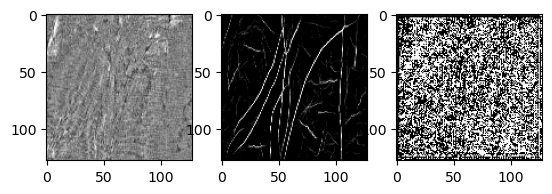

In [6]:
#Plot from val/test tensor
from PIL import Image
def generate_pic(my_nn,tensor_x_val,tensor_y_val,im_nr=25):
    image = tensor_x_val[im_nr,:,:]
    
    image = torch.unsqueeze(image,0)
    image = torch.unsqueeze(image,0)
    
    image_target = tensor_y_val[im_nr,:,:]
    y_pred = my_nn.forward(image)
    y_pred = torch.squeeze(y_pred)
    y_pred=y_pred.detach().numpy()
    image_target = image_target.detach().numpy()
    image =torch.squeeze(image)
    image = image.detach().numpy()
    y_pred=convToBinary(y_pred)
    plt.subplot(1,3,1)
    plt.imshow(image,cmap="gray")
    plt.subplot(1,3,2)
    plt.imshow(image_target,cmap="gray")
    plt.subplot(1,3,3)
    plt.imshow(y_pred,cmap="gray")
    plt.show()
#my_loaded_network = Net()
#my_loaded_network.load_state_dict(torch.load("models/model_12"))
generate_pic(my_nn.to(device="cpu"),tensor_x_val,tensor_y_val,im_nr=5)

In [ ]:
import os
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/Emil_Csnet_victor_masks_v1")
# Set the value DEBUG variable
os.environ.setdefault('PYTORCH_ENABLE_MPS_FALLBACK', "1")
costval = []
test_accuracy_list =[]
f1_scores = []
#my_nn = Net().to(device=device)
my_nn = Net(channels=1,classes=1).to(device=device)
#mps_device=torch.device("mps")
#my_nn.to(mps_device)
criterion = nn.BCELoss()
#criterion2 = nn.
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(my_nn.parameters())#,lr=0.01)#,weight_decay=1e-5)#,lr=0.01)

epochs=400
start=0
count=0
torch.autograd.set_detect_anomaly(True)
for j in range(start,start+epochs):
  print(j,"-------------------------------------------------")
  my_nn.train()
  for i,(x_train,y_train) in enumerate(my_dataloader):
    x_train = x_train.to(device=device)
    y_train = y_train.to(device=device)
    x_train = torch.unsqueeze(x_train,1)
    y_pred = my_nn.forward(x_train).to(device=device)
    y_pred = torch.squeeze(y_pred)
    #print(y_train.shape,y_pred.shape)
    cost = criterion(y_pred,y_train)
    #print(cost)
    writer.add_scalar("train/cost", cost, count)
    count+=1

    #backprop
    optimizer.zero_grad()
    
    cost.backward()
    optimizer.step()
  my_nn.eval()
  #costval.append(cost)
  #print(cost)
  torch.save(my_nn.state_dict(),"models/model_"+str(j))
  accuracy=test_acc(my_nn,my_dataloader_val)
  f1_s = f1(my_nn,my_dataloader_val)
  print("cost,MSE,F1:",cost,accuracy,f1_s)
  writer.add_scalar("val/accuracy", accuracy, j)
  writer.add_scalar("val/f1", f1_s, j)
  #costval.append(cost)
  #test_accuracy_list.append(accuracy)
  #f1_scores.append(f1_s)
  generate_pic(my_nn.to(device="cpu"),tensor_x_val,tensor_y_val,im_nr=25)
  my_nn.to(device=device)